<a href="https://colab.research.google.com/github/changbai-phu/Currency_Exchange_Rate_Predict/blob/main/Different_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance requests beautifulsoup4 pandas pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.6 MB/s eta 0:00:00


## 1. Data Preparation

In [2]:
#google page only has real time data, need to go to yahoo finance for historical data
import yfinance as yf

# Get last 6 months of daily data
df = yf.download("CADCNY=X", start="2025-02-01", end="2025-08-01", interval='1d')
df = df[['Close']]
df.reset_index(inplace=True)
df.columns = ['Date', 'Rate']

df.to_csv("cad_cny_history.csv", index=False)
print(df.tail())

/tmp/ipython-input-3523705728.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("CADCNY=X", start="2025-02-01", end="2025-08-01", interval='1d')
[*********************100%***********************]  1 of 1 completed

          Date      Rate
122 2025-07-25  5.243906
123 2025-07-28  5.220485
124 2025-07-29  5.226109
125 2025-07-30  5.209860
126 2025-07-31  5.190529


In [3]:
df.head()

,Date,Rate
0,2025-02-03,4.883466
1,2025-02-04,4.989753
2,2025-02-05,5.010937
3,2025-02-06,5.078317
4,2025-02-07,5.093781


### 2. Model Forecast

### A. ARIMA (AutoRegressive Integrated Moving Average)
- Good for stationary data, using differencing to calculate linear/polynomial trends
- Good for short-term forecasting
- Good for no strong seasonal patterns
- Used in finance, weather forecasting, demand prediction etc

ARIMA(p, d, q)
- p =  number of autoregressive terms
- d = number of differences to make the series stationary
- q = number of moving average terms



In [4]:
# Import necessary libraries for ARIMA
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
# df = pd.read_csv("cad_cny_history.csv")

# Prepare data for ARIMA - ARIMA requires a time series with a DatetimeIndex
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

#### Determine best fit p, d, q

1. Choose p using PACF (partial autocorrelation function)
  - if PACF cuts off after lag k - p=k
  - else, p=0
2. Choose d using ADF Test (Augmented Dickey-Fuller)
  - usually d = 0, 1 or at most 2
  - p > 0.05 - not stationary - apply differencing d=1 or more
  - p <= 0.05 - stationary - d=0
3. Choose q using ACF (autocorrelation function)
  - if ACF cuts off sharply after lag k - q=k
  - else, q=0



In [5]:
import numpy as np
import itertools
from statsmodels.tsa.arima.model import ARIMA

def find_best_arima_parameters(data, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3)):
  """find the best arima parameters to minimize AIC"""
  best_aic = np.inf
  best_order = None
  best_model = None

  for p, d, q in itertools.product(
        range(p_range[0], p_range[1] + 1),
        range(d_range[0], d_range[1] + 1),
        range(q_range[0], q_range[1] + 1)
    ):
        try:
            model = ARIMA(data, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic

            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
                best_model = model_fit

        except:
            continue

  return best_order, best_aic, best_model


best_order, best_aic, best_model = find_best_arima_parameters(df['Rate'])
print("Best (p,d,q):", best_order)
print("Best AIC:", best_aic)
print(best_model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best (p,d,q): (0, 1, 3)
Best AIC: -602.2361115254377
                               SARIMAX Results                                
Dep. Variable:                   Rate   No. Observations:                  127
Model:                 ARIMA(0, 1, 3)   Log Likelihood                 305.118
Date:                Mon, 18 Aug 2025   AIC                           -602.236
Time:                        06:47:06   BIC                           -590.891
Sample:                             0   HQIC                          -597.627
                                - 127                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0834      0.088      0.946      0.344      -0.089       0.256
ma.L2          0.2571      0.065      3.951      0.000       0.130       0.385

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Can also use exisitng **auto_arima** to find the best ARIMA parameters.  (Having dependencies issue, need certain version of other packages, listing below:
- numpy: 1.26.4
- python: 3.12.x
- pandas: 2.2.2
- refer to issue reported here: https://github.com/alkaline-ml/pmdarima/issues/577)

In [ ]:
from pmdarima import auto_arima

# seasonal=False assuming no strong seasonal patterns
# trace=True will show the progress of the search
best_model = auto_arima(df['Rate'], seasonal=False, trace=True)

# Print the best ARIMA order found
print("Best ARIMA order (p, d, q):", best_model.order)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [11]:
import numpy as np
import itertools
from statsmodels.tsa.arima.model import ARIMA

# Calculate best ARIMA parameters using BIC method to compare with AIC
def find_best_arima_parameters_bic(data, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3)):
  """find the best arima parameters to minimize AIC"""
  best_bic = np.inf
  best_order = None
  best_model = None

  for p, d, q in itertools.product(
        range(p_range[0], p_range[1] + 1),
        range(d_range[0], d_range[1] + 1),
        range(q_range[0], q_range[1] + 1)
    ):
        try:
            model = ARIMA(data, order=(p, d, q))
            model_fit = model.fit()
            bic = model_fit.bic

            if bic < best_bic:
                best_bic = bic
                best_order = (p, d, q)
                best_model = model_fit

        except:
            continue

  return best_order, best_aic, best_model


best_order_bic, best_bic, best_model_bic = find_best_arima_parameters_bic(df['Rate'])
print("Best (p,d,q):", best_order_bic)
print("Best AIC:", best_bic)
print(best_model_bic.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best (p,d,q): (0, 1, 0)
Best AIC: -602.2361115254377
                               SARIMAX Results                                
Dep. Variable:                   Rate   No. Observations:                  127
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 299.765
Date:                Mon, 18 Aug 2025   AIC                           -597.529
Time:                        07:09:16   BIC                           -594.693
Sample:                             0   HQIC                          -596.377
                                - 127                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   3.69e-05     13.596      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
order_manual=(5,1,0)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Forecasted Rates for the next 14 days:
         Date  Forecasted_Rate
0  2025-08-01         5.190529
1  2025-08-02         5.190529
2  2025-08-03         5.190529
3  2025-08-04         5.190529
4  2025-08-05         5.190529
5  2025-08-06         5.190529
6  2025-08-07         5.190529
7  2025-08-08         5.190529
8  2025-08-09         5.190529
9  2025-08-10         5.190529
10 2025-08-11         5.190529
11 2025-08-12         5.190529
12 2025-08-13         5.190529
13 2025-08-14         5.190529


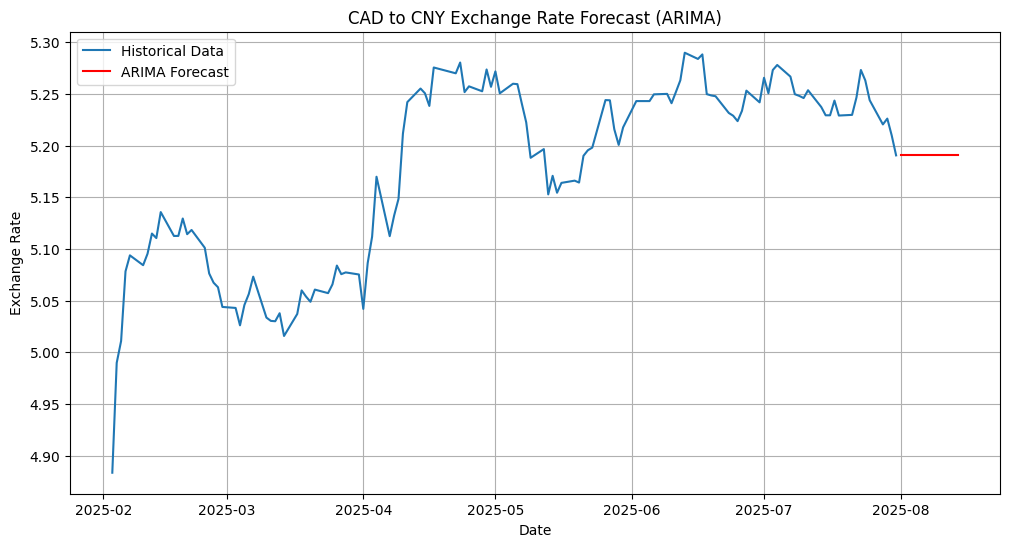

In [12]:
# Fit the ARIMA model
model = ARIMA(df['Rate'], order=best_order_bic) #replace order=best_order to use the calculated order
model_fit = model.fit()

# Make predictions for the next 14 days
forecast_steps = 14
forecast = model_fit.forecast(steps=forecast_steps)

# Create a date range for the forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_Rate': forecast.values})

# Display the forecasted rates
print("Forecasted Rates for the next 14 days:")
print(forecast_df)

# Optional: Plot the historical data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Rate'], label='Historical Data')
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Rate'], color='red', label='ARIMA Forecast')
plt.title('CAD to CNY Exchange Rate Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
start_rate = forecast_df['Forecasted_Rate'].iloc[0]
end_rate = forecast_df['Forecasted_Rate'].iloc[-1]
rate_change = end_rate - start_rate
trend = "increase" if rate_change > 0 else "decrease" if rate_change < 0 else "remain stable"

start_day = forecast_df['Date'].iloc[0]
end_day = forecast_df['Date'].iloc[-1]

summary = (
    f"The CAD to CNY exchange rate is forecasted to {trend} by "
    f"{abs(rate_change)/start_rate*100:.2f}% over the next 14 days, "
    f"from {start_rate:.4f} to {end_rate:.4f} for date: {start_day} to {end_day}."
)

print("Prediction Summary:")
print(summary)

Prediction Summary:
The CAD to CNY exchange rate is forecasted to increase by 0.04% over the next 14 days, from 5.1827 to 5.1846 for date: 2025-08-01 00:00:00 to 2025-08-14 00:00:00.


### B. LSTM

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Rate'].values.reshape(-1, 1))

#Prepare sequences
sequence_length = 60 #for past 60 days
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  #3D input for LSTM

#Build Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

#Train model
model.fit(X, y, epochs=100, batch_size=32)

#Prediction
forecast_steps = 14
predictions = []
last_60_days = scaled_data[-sequence_length:]
for _ in range(forecast_steps):
    x_input = last_60_days[-sequence_length:]
    x_input = np.reshape(x_input, (1, sequence_length, 1))
    prediction = model.predict(x_input)
    predictions.append(prediction[0][0])
    last_60_days = np.append(last_60_days[1:], prediction[0][0])

predicted_rates = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
#print(f"Predicted rate for the next 14 days: ", predicted_rates.flatten())

# Create a date range for the forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Create a DataFrame for the forecast
lstm_forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_Rate': predicted_rates.flatten()})

# Display the forecasted rates
print("Forecasted Rates for the next 14 days (LSTM):")
display(lstm_forecast_df)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.7860
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.4094
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1098
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0266
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0814
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0141
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0135
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0313
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0294
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0164
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0070
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0080
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0118
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0108
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0069
Epoch 16/100
3/3 ━━━━━━━━━━━━━━

,Date,Forecasted_Rate
0,2025-08-01,5.237658
1,2025-08-02,5.236419
2,2025-08-03,5.235827
3,2025-08-04,5.235665
4,2025-08-05,5.235771
5,2025-08-06,5.236031
6,2025-08-07,5.236368
7,2025-08-08,5.236732
8,2025-08-09,5.237094
9,2025-08-10,5.237435


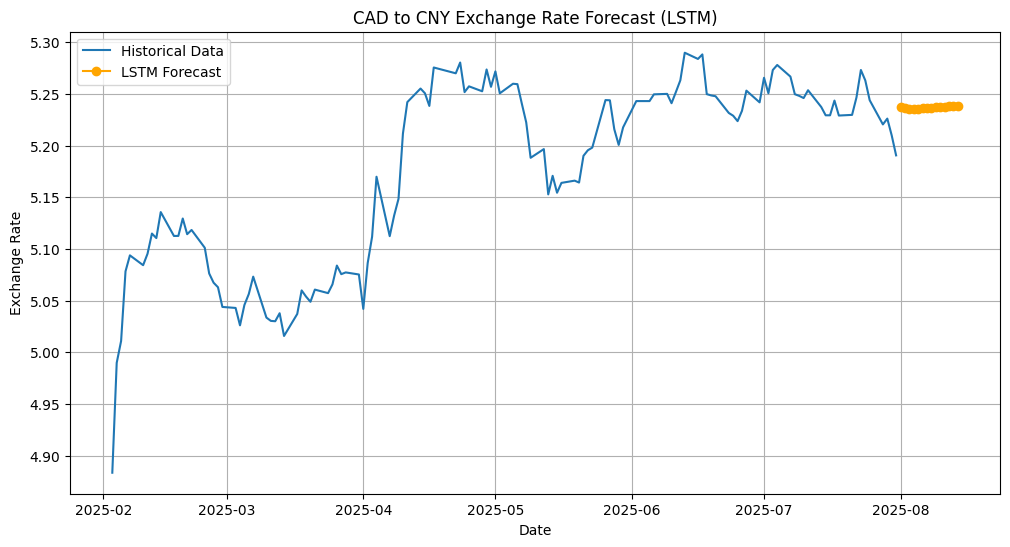

In [23]:
plt.figure(figsize=(12,6))
plt.plot(df['Rate'], label='Historical Data')
plt.plot(lstm_forecast_df['Date'], lstm_forecast_df['Forecasted_Rate'], label='LSTM Forecast', color='orange', marker='o')

plt.title('CAD to CNY Exchange Rate Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

## 3. Compare predicted results among Prophet, ARIMA, and LSTM

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Load data
df = pd.read_csv("cad_cny_history.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 2. Prophet Forecast
# Reset index to make 'Date' a column again for Prophet
df_prophet = df.reset_index()
df_prophet.columns = ['ds', 'y']
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future_prophet = model_prophet.make_future_dataframe(periods=14) #forecast 14 days
forecast_propht = model_prophet.predict(future_prophet)
prophet_forecast_values = forecast_propht['yhat'].tail(14).values
print("Forecasted Rates for the next 14 days (Prophet):", prophet_forecast_values)

# 3. ARIMA Forecast
# ARIMA model expects a DatetimeIndex, so use the original df
arima_order = best_order_bic # Use the best_order_bic calculated previously
model_arima = ARIMA(df['Rate'], order=arima_order)
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=14)
print("Forecasted Rates for the next 14 days (ARIMA):", forecast_arima)

# 4. LSTM Forecast
# LSTM model expects a DatetimeIndex, so use the original df
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Rate'].values.reshape(-1, 1))
sequence_length = 60
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X, y, epochs=100, batch_size=32)

predictions_lstm = []
last_60_days = scaled_data[-sequence_length:]
for _ in range(14):
    x_input = last_60_days[-sequence_length:]
    x_input = np.reshape(x_input, (1, sequence_length, 1))
    prediction = model_lstm.predict(x_input)
    predictions_lstm.append(prediction[0][0])
    last_60_days = np.append(last_60_days[1:], prediction[0][0])

lstm_forecast = scaler.inverse_transform(np.array(predictions_lstm).reshape(-1, 1))
print("Forecasted Rates for the next 14 days (LSTM):", lstm_forecast.flatten())

# Print predicted results in one table for convenience
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=14, freq='D')

# Combine all forecasts
comparison_df = pd.DataFrame({
    'Date': forecast_dates,
    'ARIMA': forecast_arima.values,
    'Prophet': prophet_forecast_values,
    'LSTM': lstm_forecast.flatten()
})

display(comparison_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8grioh90/e951ddi6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8grioh90/8s1lc1d7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32779', 'data', 'file=/tmp/tmp8grioh90/e951ddi6.json', 'init=/tmp/tmp8grioh90/8s1lc1d7.json', 'output', 'file=/tmp/tmp8grioh90/prophet_modelueqm70ta/prophet_model-20250818092437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

Forecasted Rates for the next 14 days (Prophet): [5.23658341 5.16074068 5.16003928 5.22257168 5.22312453 5.22350028
 5.22687041 5.23167387 5.15583114 5.15512974 5.21766214 5.21821499
 5.21859074 5.22196087]
Forecasted Rates for the next 14 days (ARIMA): 127    5.190529
128    5.190529
129    5.190529
130    5.190529
131    5.190529
132    5.190529
133    5.190529
134    5.190529
135    5.190529
136    5.190529
137    5.190529
138    5.190529
139    5.190529
140    5.190529
Name: predicted_mean, dtype: float64
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.6620
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1621
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0429
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0798
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0101
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0177
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0321
Epoch 8/100
3/3 ━━━━━━━━━━━━━━

,Date,ARIMA,Prophet,LSTM
0,2025-08-01,5.190529,5.236583,5.235271
1,2025-08-02,5.190529,5.160741,5.233711
2,2025-08-03,5.190529,5.160039,5.233109
3,2025-08-04,5.190529,5.222572,5.233094
4,2025-08-05,5.190529,5.223125,5.233434
5,2025-08-06,5.190529,5.223500,5.233972
6,2025-08-07,5.190529,5.226870,5.234610
7,2025-08-08,5.190529,5.231674,5.235284
8,2025-08-09,5.190529,5.155831,5.235950
9,2025-08-10,5.190529,5.155130,5.236585


,Date,ARIMA,Prophet,LSTM
0,2025-08-01,5.190529,5.236583,5.235271
1,2025-08-02,5.190529,5.160741,5.233711
2,2025-08-03,5.190529,5.160039,5.233109
3,2025-08-04,5.190529,5.222572,5.233094
4,2025-08-05,5.190529,5.223125,5.233434
5,2025-08-06,5.190529,5.223500,5.233972
6,2025-08-07,5.190529,5.226870,5.234610
7,2025-08-08,5.190529,5.231674,5.235284
8,2025-08-09,5.190529,5.155831,5.235950
9,2025-08-10,5.190529,5.155130,5.236585


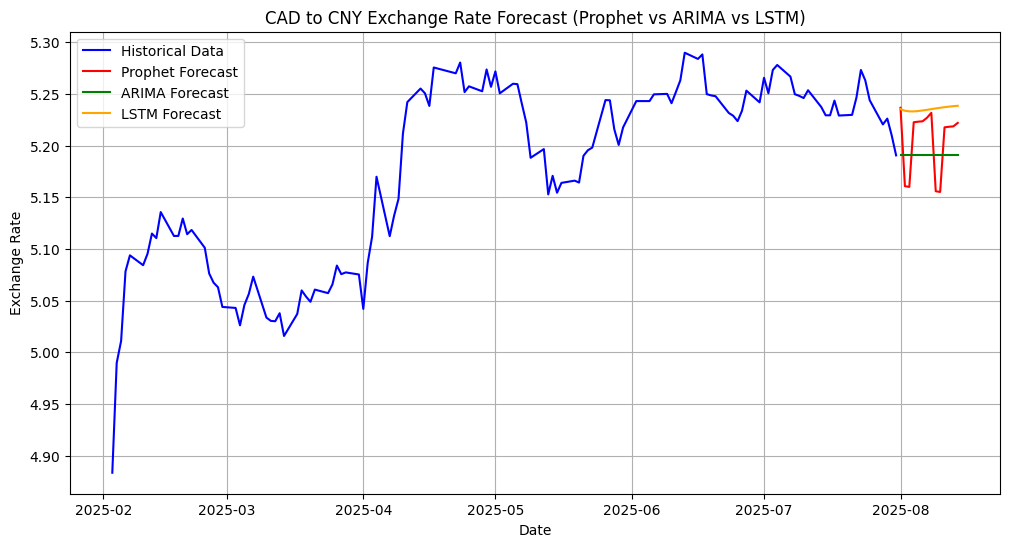

In [27]:
# Print predicted results in one table for convenience
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=14, freq='D')

# Combine all forecasts
comparison_df = pd.DataFrame({
    'Date': forecast_dates,
    'ARIMA': forecast_arima.values,
    'Prophet': prophet_forecast_values,
    'LSTM': lstm_forecast.flatten()
})

display(comparison_df)

plt.figure(figsize=(12, 6))
plt.plot(df['Rate'], label='Historical Data', color='blue')
plt.plot(forecast_dates, prophet_forecast_values, color='red', label='Prophet Forecast')
plt.plot(forecast_dates, forecast_arima, color='green', label='ARIMA Forecast')
plt.plot(forecast_dates, lstm_forecast.flatten(), color='orange', label='LSTM Forecast')
plt.title('CAD to CNY Exchange Rate Forecast (Prophet vs ARIMA vs LSTM)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

## 4. Compare the predicted results with actual values

/tmp/ipython-input-1791823460.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  actual_14_df = yf.download("CADCNY=X", start="2025-08-02", end="2025-08-16", interval='1d')
[*********************100%***********************]  1 of 1 completed


         Date     ARIMA   Prophet      LSTM    Actual
0  2025-08-01  5.190529  5.236583  5.235271       NaN
1  2025-08-02  5.190529  5.160741  5.233711       NaN
2  2025-08-03  5.190529  5.160039  5.233109       NaN
3  2025-08-04  5.190529  5.222572  5.233094  5.233572
4  2025-08-05  5.190529  5.223125  5.233434  5.212592
5  2025-08-06  5.190529  5.223500  5.233972  5.216703
6  2025-08-07  5.190529  5.226870  5.234610  5.227714
7  2025-08-08  5.190529  5.231674  5.235284  5.228991
8  2025-08-09  5.190529  5.155831  5.235950       NaN
9  2025-08-10  5.190529  5.155130  5.236585       NaN
10 2025-08-11  5.190529  5.217662  5.237165  5.221273
11 2025-08-12  5.190529  5.218215  5.237681  5.218120
12 2025-08-13  5.190529  5.218591  5.238132  5.213012
13 2025-08-14  5.190529  5.221961  5.238509  5.216554
Prophet - MAE: 0.01, RMSE: 0.01
ARIMA - MAE: 0.03, RMSE: 0.03
LSTM - MAE: 0.01, RMSE: 0.02


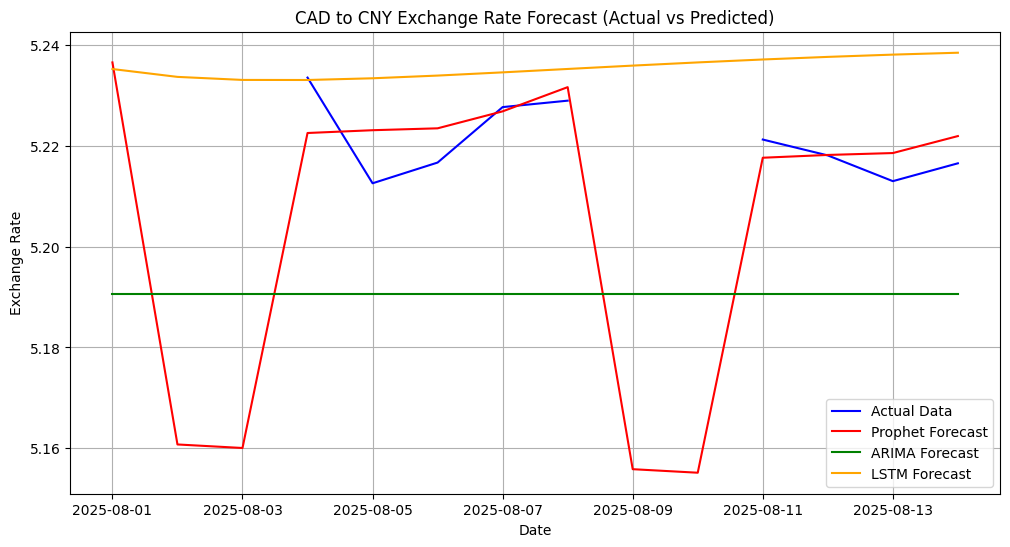

In [30]:
import yfinance as yf

# Get the 14 days of actual data
actual_14_df = yf.download("CADCNY=X", start="2025-08-02", end="2025-08-16", interval='1d')
actual_14_df = actual_14_df[['Close']]
actual_14_df = actual_14_df.reset_index()
actual_14_df.columns = ['Date', 'Actual']

# Merge with existing predicted results
merged = pd.merge(comparison_df, actual_14_df, on='Date', how='left')
print(merged)

# Calculate MAE and RMSE
def mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

for model in ['Prophet', 'ARIMA', 'LSTM']:
    mae_value = mae(merged['Actual'], merged[model])
    rmse_value = rmse(merged['Actual'], merged[model])
    print(f"{model} - MAE: {mae_value:.2f}, RMSE: {rmse_value:.2f}")


# Plot
plt.figure(figsize=(12, 6))
plt.plot(merged['Date'], merged['Actual'], label='Actual Data', color='blue')
plt.plot(merged['Date'], merged['Prophet'], color='red', label='Prophet Forecast')
plt.plot(merged['Date'], merged['ARIMA'], color='green', label='ARIMA Forecast')
plt.plot(merged['Date'], merged['LSTM'], color='orange', label='LSTM Forecast')

plt.title('CAD to CNY Exchange Rate Forecast (Actual vs Predicted)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()